In [1]:
import numpy as np
import pandas as pd
import mrcfile
import matplotlib.pyplot as plt

from torch_find_peaks import find_peaks_3d
from fle_3d import FLEBasis3D

In [2]:
# Choosing one large protein (per recommendation)
TEMPLATE_PATH = "4CR2_10.00A_solvent-4.530V_real.mrc"

with mrcfile.open(TEMPLATE_PATH, permissive=True) as m:
    template = m.data.astype(np.float32)

print("Template shape:", template.shape)

Template shape: (33, 33, 33)


/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)


In [3]:
# building fle 3d and RI volume

fle = FLEBasis3D(
    N=template.shape[0],
    bandlimit=32,
    eps=1e-4
)

def rotation_invariant_volume(fle, volume):
    coeffs = fle.evaluate_t(volume)
    coeffs_tmp = np.zeros_like(coeffs)
    for k in fle.idlm_list[0][0]:   # l=0, m=0 only
        coeffs_tmp[k] = coeffs[k]
    return fle.evaluate(coeffs_tmp).real

template_ri = rotation_invariant_volume(fle, template)

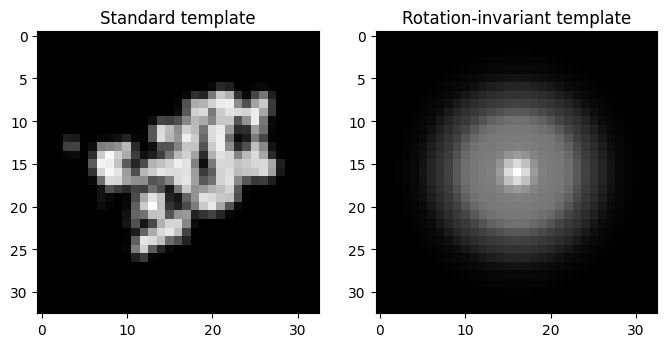

In [4]:
mid = template.shape[0] // 2

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(template[mid], cmap="gray")
axs[0].set_title("Standard template")

axs[1].imshow(template_ri[mid], cmap="gray")
axs[1].set_title("Rotation-invariant template")

plt.show()

In [5]:
with mrcfile.open("grandmodel.mrc", permissive=True) as m:
    grand_model = m.data.astype(np.float32)

with mrcfile.open("reconstruction.mrc", permissive=True) as m:
    reconstruction = m.data.astype(np.float32)

print("Grand model shape:", grand_model.shape)
print("Reconstruction shape:", reconstruction.shape)

/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


Grand model shape: (180, 512, 512)
Reconstruction shape: (512, 512, 512)


In [48]:
def compute_cc2(volume, ref):
    # zero-pad template to volume size
    pad = np.zeros_like(volume)
    sz = ref.shape[0]
    pad[:sz, :sz, :sz] = ref

    F_vol = np.fft.fftn(volume)
    F_ref = np.fft.fftn(pad)

    cc = np.real(np.fft.ifftn(F_vol * np.conj(F_ref)))
    
    return cc

In [6]:
def compute_cc(vol, ref):
    ref_original_shape = ref.shape
    if ref.shape != vol.shape:
        # Apply zero-padding to the smaller volume
        
        max_shape = np.maximum(ref.shape, vol.shape)
        ref_padded = np.zeros(max_shape, dtype=ref.dtype)
        vol_padded = np.zeros(max_shape, dtype=vol.dtype)
        ref_padded[:ref.shape[0], :ref.shape[1], :ref.shape[2]] = ref
        vol_padded[:vol.shape[0], :vol.shape[1], :vol.shape[2]] = vol
        ref, vol = ref_padded, vol_padded
    assert ref.shape == vol.shape, "Volumes must have the same shape after padding."
    print("Computing CC for volumes of shape:", ref.shape)

    F1 = np.fft.fftn(ref)
    F2 = np.fft.fftn(vol)
    cc = np.fft.ifftn(F2 * np.conj(F1))
    cc= np.real(cc)
    cc = np.roll(cc, shift=(ref_original_shape[0]//2, ref_original_shape[1]//2, ref_original_shape[2]//2), axis=(0,1,2))
    return cc , ref

In [7]:
#cc_std = compute_cc(grand_model, template)
#cc_ri  = compute_cc(grand_model, template_ri)





cc_std, ref_padded = compute_cc(grand_model, template)

cc_ri, ref_padded_ri = compute_cc(grand_model, template_ri)
cc_std = np.maximum(cc_std, 0)
cc_ri  = np.maximum(cc_ri, 0)
print("CC volumes computed")

Computing CC for volumes of shape: (180, 512, 512)


Computing CC for volumes of shape: (180, 512, 512)
CC volumes computed


In [51]:
# cc_std=np.roll(cc_std, shift=template.shape[0]//2, axis=(0,1,2))
# cc_ri=np.roll(cc_ri, shift=template.shape[0]//2, axis=(0,1,2))

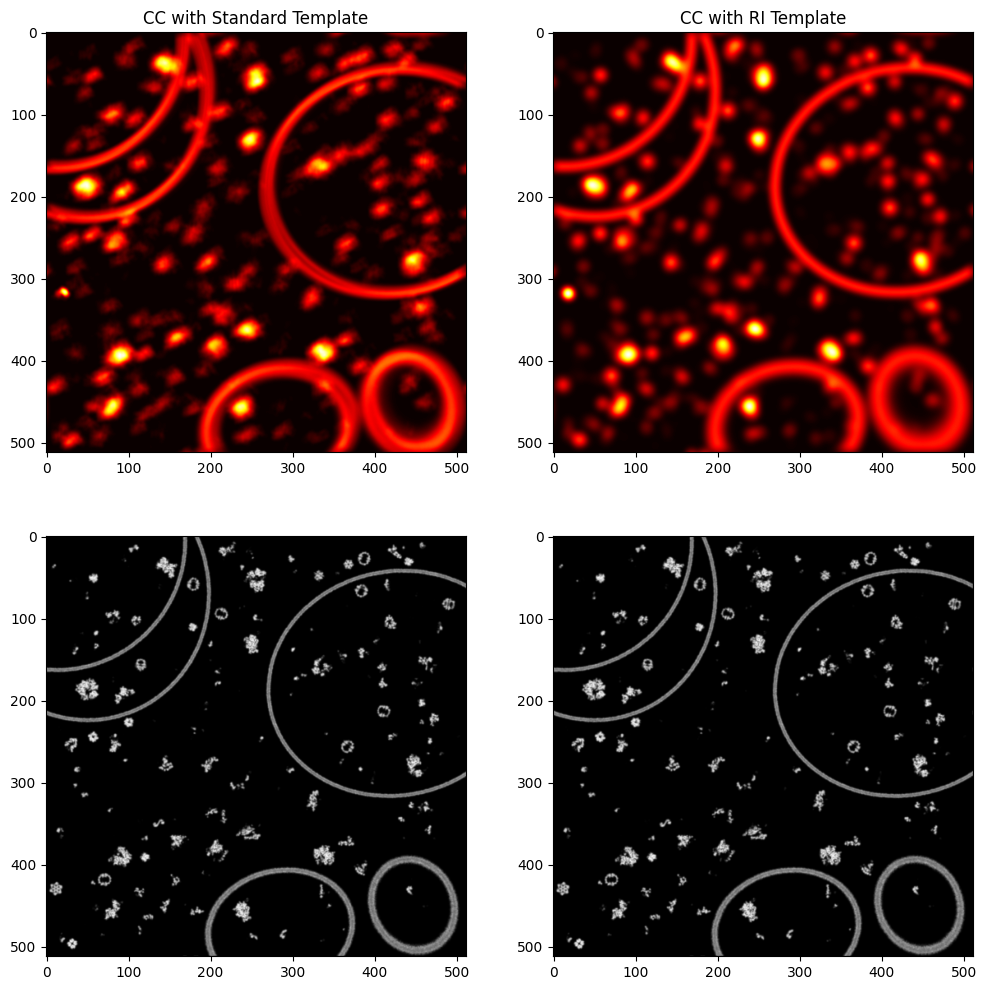

In [8]:
# import matplotlib.pyplot as plt
# fig, axs = plt.subplots(2,2, figsize=(10,8))
# axs[0,0].imshow(cc_std[cc_std.shape[0]//2], cmap="gray")
# axs[0,0].set_title("STD CC (standard)")
# axs[0,1].imshow(cc_ri[cc_ri.shape[0]//2], cmap="gray")
# axs[0,1].set_title("RI CC (reconstruction)")
# axs[1,0].imshow(grand_model[grand_model.shape[0]//2], cmap="gray")
# axs[1,0].set_title("Reconstruction slice")
# axs[1,1].imshow(template[mid], cmap="gray")
# axs[1,1].set_title("Template slice")
# plt.show()
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12,12))
mid = cc_std.shape[0] // 2
ax[0, 0].imshow(cc_std[mid], cmap="hot")
ax[0, 0].set_title("CC with Standard Template")
ax[0, 1].imshow(cc_ri[mid], cmap="hot")
ax[0, 1].set_title("CC with RI Template")
ax[1,0].imshow(grand_model[mid], cmap="gray")
ax[1,1].imshow(grand_model[mid], cmap="gray")

In [9]:
print("Tomogram shape:", reconstruction.shape)
print("Template shape:", template.shape, template_ri.shape)

Tomogram shape: (512, 512, 512)
Template shape: (33, 33, 33) (33, 33, 33)


In [10]:
from torch_find_peaks import find_peaks_3d

# Detect peaks
peaks_std = find_peaks_3d(
    cc_std,
    min_distance=1,
    threshold_abs=0.001,
    return_as="torch"
)

peaks_ri = find_peaks_3d(
    cc_ri,
    min_distance=1,
    threshold_abs=0.001,
    return_as="torch"
)

print("STD peaks:", peaks_std[0].shape)
print("RI  peaks:", peaks_ri[0].shape)

STD peaks: torch.Size([9422, 3])
RI  peaks: torch.Size([6026, 3])


In [55]:
#filtering peaks. top-K strongest detections, not all peaks.
# TOPK = 50

# idx_std = peaks_std[1].argsort(descending=True)[:TOPK]
# idx_ri  = peaks_ri[1].argsort(descending=True)[:TOPK]

# top_std = peaks_std[0][idx_std]
# top_ri  = peaks_ri[0][idx_ri]

# scores_std = peaks_std[1][idx_std]
# scores_ri  = peaks_ri[1][idx_ri]

# print("Top STD peak score:", scores_std[0].item())
# print("Top RI  peak score:", scores_ri[0].item())

tensor([[  0,   0, 388],
        [  0,  12, 459],
        [  0,  18, 124],
        ...,
        [179, 494, 359],
        [179, 497, 360],
        [179, 511, 148]])
80


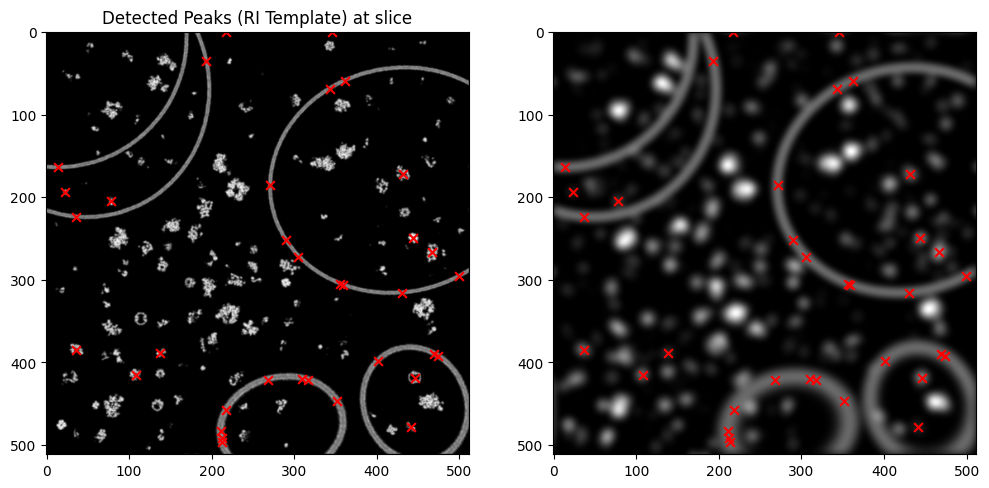

In [11]:
print(peaks_ri[0])

slice_id = 80
print(slice_id)


#x_coord, y_coord = y_coord, x_coord  # swapped in pea
# ks

#print(sl)
# take all peaks that are at mid slice
subset_mask = peaks_ri[0][:,0] == slice_id
subset_peaks_ri = peaks_ri[0][subset_mask]

# Mark the peaks on the image
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].imshow(grand_model[slice_id], cmap="gray")
ax[0].scatter(subset_peaks_ri[:,2], subset_peaks_ri[:,1], c='r', s=40, marker='x')
ax[0].set_title("Detected Peaks (RI Template) at slice")
ax[1].imshow(cc_ri[slice_id], cmap="gray")
ax[1].scatter(subset_peaks_ri[:,2], subset_peaks_ri[:,1], c='r', s=40, marker='x')

In [17]:
TOPK = 5000 # checking with different values
top_std = peaks_std[0][peaks_std[1].argsort(descending=True)[:TOPK]] # is size of template,shape[0] //2

print(cc_ri.shape)
top_ri  = peaks_ri[0][peaks_ri[1].argsort(descending=True)[:TOPK]] # is size of template,shape[0] //2

print("Top peaks (ri):", top_ri)

print("scores (ri):", peaks_ri[1][peaks_ri[1].argsort(descending=True)[:TOPK]])





(180, 512, 512)
Top peaks (ri): tensor([[ 54, 425, 319],
        [ 42, 381, 292],
        [ 56, 250, 107],
        ...,
        [ 61, 511, 389],
        [179,  82, 498],
        [179,  83, 500]])
scores (ri): tensor([29535.1553, 25747.3693, 20313.4337,  ...,  2696.8953,  2656.7628,
         2655.6082], dtype=torch.float64)


In [58]:
# import pandas as pd

# gt = pd.read_csv(
#     "particle_locations.txt",
#     sep=r"\s+",
#     header=None,
#     names=["label", "z", "y", "x", "rot1", "rot2", "rot3"]
# )

# # Keeping only protein particles (include vesicle + fiducial)
# gt_protein = gt[~gt["label"].isin(["vesicle", "fiducial"])]
# #gt_protein = gt[gt["label"] == "5MRC"]

# gt_xyz = gt_protein[["z", "y", "x"]].values

# print("GT protein particles:", gt_xyz.shape)

In [18]:
import pandas as pd

gt = pd.read_csv(
    "particle_locations.txt",
    sep=r"\s+",
    header=None,
    names=["label", "z", "y", "x", "rot1", "rot2", "rot3"]
)
print(gt["label"].unique())
# Keeping only protein particles (include vesicle + fiducial)
gt_protein = gt[~gt["label"].isin(["vesicle", "fiducial"])]

################### Limited to only 5MRC proteins
gt_protein = gt_protein[gt_protein["label"] == "4CR2"] 
############################


gt_xyz = gt_protein[["x", "y", "z"]].values

print("GT protein particles:", gt_xyz.shape)

['vesicle' 'fiducial' '1BXN' '1U6G' '3QM1' '1S3X' '4V94_fixed' '4CR2'
 '2CG9' '3H84' '3D2F' '1QVR' '5MRC' '3GL1' '3CF3']
GT protein particles: (119, 3)


In [19]:
import numpy as np
from scipy.spatial import cKDTree

def evaluate_detections(detected_xyz, gt_xyz, max_dist=8):
    """
    detected_xyz: (N,3) array of detected peak coordinates (z,y,x)
    gt_xyz:       (M,3) array of GT particle coordinates
    max_dist:     max distance (voxels) to count as correct detection
    """
    tree = cKDTree(gt_xyz)
    matched_gt_indices = []
    distances = []

    for p in detected_xyz:
        dist, idx = tree.query(p, k=1)
        if dist <= max_dist and idx not in matched_gt_indices:
            matched_gt_indices.append(idx)
            distances.append(dist)

    return np.array(distances), np.array(matched_gt_indices)

In [20]:
#evaluating how many of those top-K are close to real particles

dist_std, hits_std_idx = evaluate_detections(
    top_std.cpu().numpy(),
    gt_xyz,
    max_dist=8
)

dist_ri, hits_ri_idx = evaluate_detections(
    top_ri.cpu().numpy(),
    gt_xyz,
    max_dist=8
)

hits_std = len(hits_std_idx)
hits_ri = len(hits_ri_idx)

print("STD hits:", hits_std, "/", TOPK)
print("RI  hits:", hits_ri,  "/", TOPK)

STD hits: 119 / 5000
RI  hits: 119 / 5000


tensor([[  0,   0, 388],
        [  0,  12, 459],
        [  0,  18, 124],
        ...,
        [179, 494, 359],
        [179, 497, 360],
        [179, 511, 148]])
18


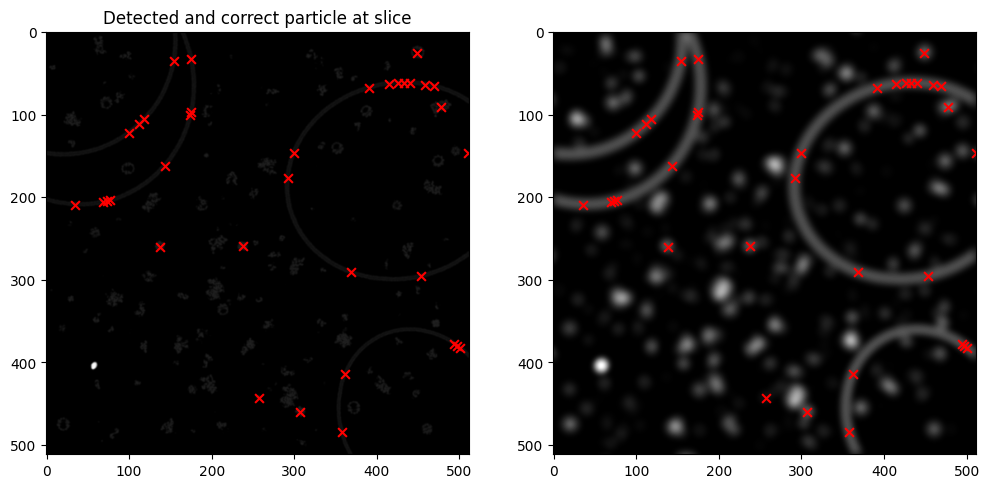

In [24]:
print(peaks_ri[0])

slice_id = 18
print(slice_id)


#x_coord, y_coord = y_coord, x_coord  # swapped in pea
# ks


# take all peaks that are at mid slice


subset_peaks_ri = peaks_ri[0][peaks_ri[0][:,0] == slice_id]
# Filter to only matched detections
subset_gt_ri = gt_xyz[hits_ri_idx][gt_xyz[hits_ri_idx][:,0] == slice_id]




# Mark the peaks on the image
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].imshow(grand_model[slice_id], cmap="gray")
ax[0].scatter(subset_peaks_ri[:,2], subset_peaks_ri[:,1], c='r', s=40, marker='x')
ax[0].set_title("Detected and correct particle at slice")
ax[1].imshow(cc_ri[slice_id], cmap="gray")
ax[1].scatter(subset_peaks_ri[:,2], subset_peaks_ri[:,1], c='r', s=40, marker='x')

In [63]:
# def unwrap_fft_coords(peaks, shape):
#     """
#     Convert FFT-wrapped coordinates to spatial coordinates
#     """
#     peaks = peaks.clone()
#     for d in range(3):
#         peaks[:, d] = (peaks[:, d] + shape[d]//2) % shape[d]
#     return peaks

In [64]:
00# top_std_unwrapped = unwrap_fft_coords(top_std, cc_std.shape)
# t00sssss
# 
# 
# 
# op_ri_unwrapped  = unwrap_fft_coords(top_ri,  cc_ri.shape)

0

In [65]:
# dist_std, hits_std = evaluate_detections(
#     top_std_unwrapped.cpu().numpy(),
#     gt_xyz,
#     max_dist=8
# )

# dist_ri, hits_ri = evaluate_detections(
#     top_ri_unwrapped.cpu().numpy(),
#     gt_xyz,
#     max_dist=8
# )

# print("STD hits:", hits_std)
# print("RI  hits:", hits_ri)

In [66]:


# # Loading GT
# gt = pd.read_csv(
#     "particle_locations.txt",
#     sep=r"\s+",
#     header=None,
#     names=["label", "z", "y", "x", "rot1", "rot2", "rot3"]
# )

# # Trying out  a different template
# TEMPLATE_LABEL = "5MRC"

# gt_target = gt[gt["label"] == TEMPLATE_LABEL]
# gt_xyz = gt_target[["z", "y", "x"]].values

# print("Evaluating protein:", TEMPLATE_LABEL)
# print("GT count:", len(gt_xyz))

In [67]:


# gt = pd.read_csv(
#     "particle_locations.txt",
#     sep=r"\s+",
#     header=None,
#     names=["label", "z", "y", "x", "rot1", "rot2", "rot3"]
# )
# print(gt["label"].unique())
# # Keeping only protein particles (include vesicle + fiducial)
# gt_protein = gt[~gt["label"].isin(["vesicle", "fiducial"])]

# ################### Limited to only 5MRC proteins
# gt_protein = gt_protein[gt_protein["label"] == "5MRC"] 
# ############################


# gt_xyz = gt_protein[["x", "y", "z"]].values

# print("GT protein particles:", gt_xyz.shape)

In [68]:
# evaluate_detections is already defined above, no need to redefine

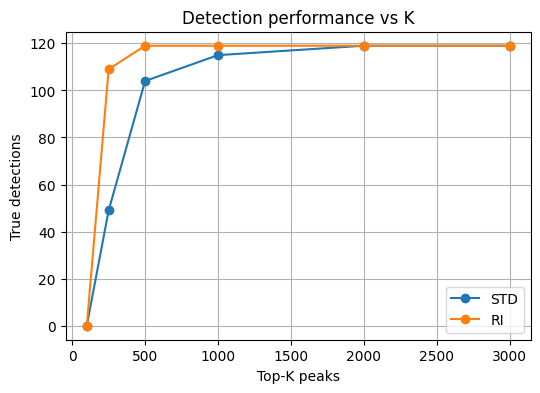

In [25]:
Ks = [100, 250, 500, 1000, 2000, 3000]
hits_std, hits_ri = [], []

for K in Ks:
    top_std = peaks_std[0][peaks_std[1].argsort(descending=True)[:K]] 
    top_ri  = peaks_ri[0][peaks_ri[1].argsort(descending=True)[:K]]  

    dist_std, h_std_idx = evaluate_detections(top_std.cpu().numpy(), gt_xyz, max_dist=8)
    dist_ri, h_ri_idx  = evaluate_detections(top_ri.cpu().numpy(),  gt_xyz, max_dist=8)

    hits_std.append(len(dist_std))
    hits_ri.append(len(dist_ri))

# Plot
plt.figure(figsize=(6,4))
plt.plot(Ks, hits_std, marker="o", label="STD")
plt.plot(Ks, hits_ri,  marker="o", label="RI")
plt.xlabel("Top-K peaks")
plt.ylabel("True detections")
plt.title("Detection performance vs K")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
def extract_patch(volume, center, size=32):
    x,y,z = map(int, center)
    h = size // 2
    return volume[ x-h:x+h,y-h:y+h,z-h:z+h]

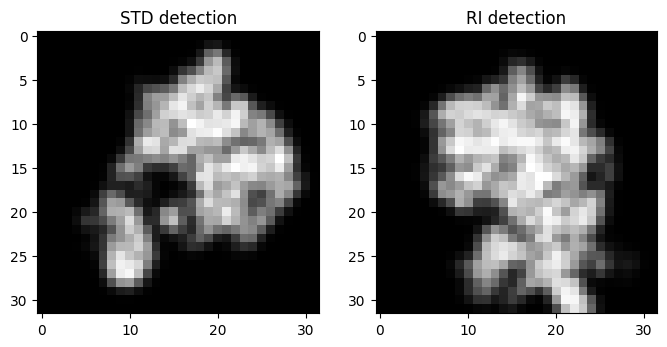

In [27]:
# Picking one mid-ranked detection (not rank 1, often fiducial)
idx = 43

z_std, y_std, x_std = top_std[idx].cpu().numpy().astype(int)
z_ri,  y_ri,  x_ri  = top_ri[idx].cpu().numpy().astype(int)

patch_std = extract_patch(grand_model, (z_std, y_std, x_std))
patch_ri  = extract_patch(grand_model, (z_ri,  y_ri,  x_ri))

fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].imshow(patch_std[patch_std.shape[0]//2], cmap="gray")
axs[0].set_title("STD detection")
axs[1].imshow(patch_ri[patch_ri.shape[0]//2], cmap="gray")
axs[1].set_title("RI detection")
plt.show()

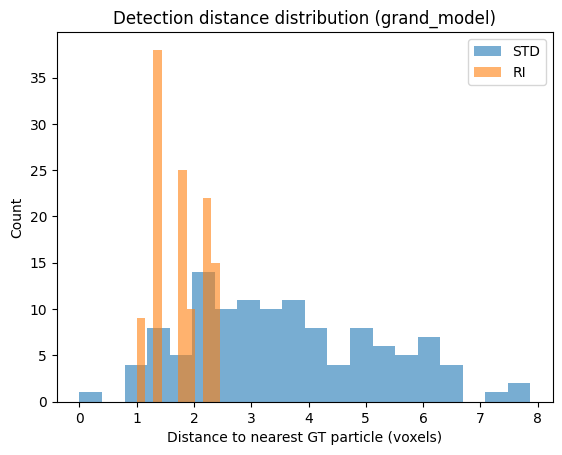

In [29]:
plt.hist(dist_std, bins=20, alpha=0.6, label="STD")
plt.hist(dist_ri, bins=10, alpha=0.6, label="RI")
plt.xlabel("Distance to nearest GT particle (voxels)")
plt.ylabel("Count")
plt.legend()
plt.title("Detection distance distribution (grand_model)")
plt.show()

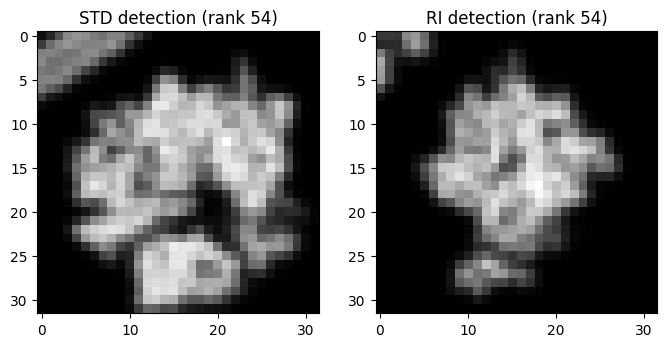

In [30]:
rank = 54
patch_ri = extract_patch(grand_model, top_ri[rank], size=32)
patch_std = extract_patch(grand_model, top_std[rank], size=32)
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].imshow(patch_std[patch_std.shape[0]//2], cmap="gray")
axs[0].set_title(f"STD detection (rank {rank})")
axs[1].imshow(patch_ri[patch_ri.shape[0]//2], cmap="gray")
axs[1].set_title(f"RI detection (rank {rank})")
plt.show()

In [37]:
# Loading reconstruction for comparison

rec = mrcfile.open("reconstruction_fixed.mrc", permissive=True).data.copy()

# reconstruction ≈ grand_model shifted by  offset in z axis
Z_OFFSET = (512 - 180) // 2
# Z_OFFSET = 0
gt_xyz_rec = gt_xyz.copy()
gt_xyz_rec[:, 0] += Z_OFFSET

In [ ]:
# # z_rec is in reconstruction coordinates
# z_rec = z

# # convert back to grand_model coordinates
# z_grand = z_rec - Z_OFFSET

# plt.figure(figsize=(10,4))

# plt.subplot(1,2,1)
# plt.imshow(grand_model[z_grand], cmap="gray")
# plt.title("grand_model slice")

# plt.subplot(1,2,2)
# plt.imshow(rec[z_rec], cmap="gray")
# plt.title("reconstruction slice")

# plt.show()

NameError: name 'z' is not defined

In [38]:
cc_std_rec, _ = compute_cc(rec, template)
cc_ri_rec,  _ = compute_cc(rec, template_ri)

cc_std_rec = np.maximum(-cc_std_rec, 0)
cc_ri_rec  = np.maximum(-cc_ri_rec,  0)

print("Reconstruction CC computed")

Computing CC for volumes of shape: (512, 512, 512)
Computing CC for volumes of shape: (512, 512, 512)
Reconstruction CC computed


In [39]:
from torch_find_peaks import find_peaks_3d

peaks_std_rec = find_peaks_3d(cc_std_rec, min_distance=3, threshold_abs=0.01, return_as="torch")
peaks_ri_rec  = find_peaks_3d(cc_ri_rec,  min_distance=3, threshold_abs=0.01, return_as="torch")

print("STD peaks (rec):", peaks_std_rec[0].shape)
print("RI  peaks (rec):", peaks_ri_rec[0].shape)


STD peaks (rec): torch.Size([194775, 3])
RI  peaks (rec): torch.Size([18741, 3])


z_grand: 83  valid range [0,179]


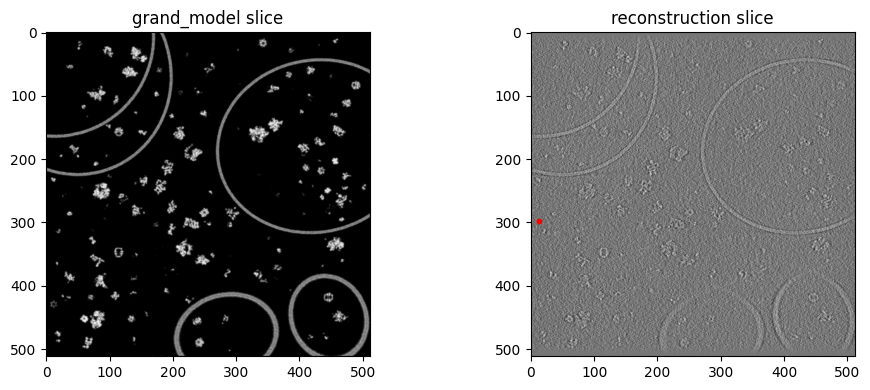

In [40]:
# pick a reasonably high-ranked RI peak
rank = 20

# peaks are (z, y, x)
z_rec, y_rec, x_rec = peaks_ri_rec[0][
    peaks_ri_rec[1].argsort(descending=True)[rank]
].cpu().numpy().astype(int)

z_grand = z_rec - Z_OFFSET
print("z_grand:", z_grand, " valid range [0,179]")
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(grand_model[z_grand], cmap="gray")
plt.title("grand_model slice")

plt.subplot(1,2,2)
plt.imshow(rec[z_rec], cmap="gray")
plt.scatter(x_rec, y_rec, c="r", s=10)
plt.title("reconstruction slice")

plt.tight_layout()
plt.show()

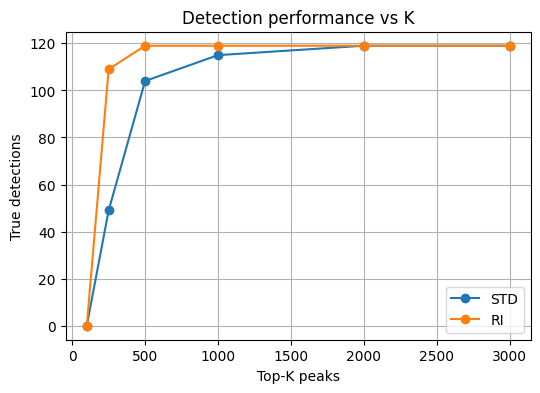

In [35]:
Ks = [100, 250, 500, 1000, 2000, 3000]
hits_std, hits_ri = [], []

for K in Ks:
    top_std = peaks_std[0][peaks_std[1].argsort(descending=True)[:K]] 
    top_ri  = peaks_ri[0][peaks_ri[1].argsort(descending=True)[:K]]  

    dist_std, h_std_idx = evaluate_detections(top_std.cpu().numpy(), gt_xyz, max_dist=8)
    dist_ri, h_ri_idx  = evaluate_detections(top_ri.cpu().numpy(),  gt_xyz, max_dist=8)

    hits_std.append(len(dist_std))
    hits_ri.append(len(dist_ri))

# Plot
plt.figure(figsize=(6,4))
plt.plot(Ks, hits_std, marker="o", label="STD")
plt.plot(Ks, hits_ri,  marker="o", label="RI")
plt.xlabel("Top-K peaks")
plt.ylabel("True detections")
plt.title("Detection performance vs K")
plt.legend()
plt.grid(True)
plt.show()

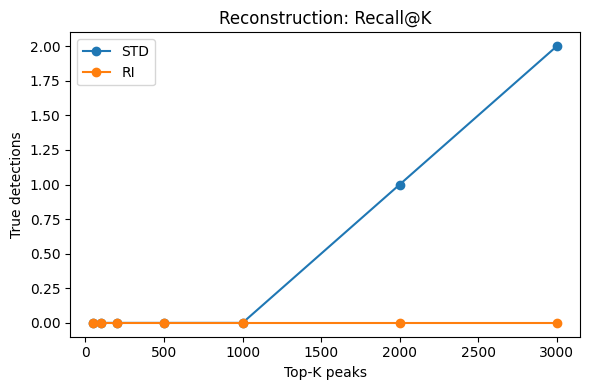

In [41]:
# Recall@K on reconstruction

Ks = [50, 100, 200, 500, 1000, 2000, 3000]
hits_std, hits_ri = [], []

for K in Ks:
    top_std = peaks_std_rec[0][peaks_std_rec[1].argsort(descending=True)[:K]] 
    top_ri  = peaks_ri_rec[0][peaks_ri_rec[1].argsort(descending=True)[:K]]  
    dist_std, h_std_idx = evaluate_detections(top_std.cpu().numpy(), gt_xyz_rec, max_dist=8)
    dist_ri, h_ri_idx  = evaluate_detections(top_ri.cpu().numpy(),  gt_xyz_rec, max_dist=8)

    hits_std.append(len(dist_std))
    hits_ri.append(len(dist_ri))

plt.figure(figsize=(6,4))
plt.plot(Ks, hits_std, "-o", label="STD")
plt.plot(Ks, hits_ri,  "-o", label="RI")
plt.xlabel("Top-K peaks")
plt.ylabel("True detections")
plt.title("Reconstruction: Recall@K")
plt.legend()
plt.tight_layout()
plt.show()

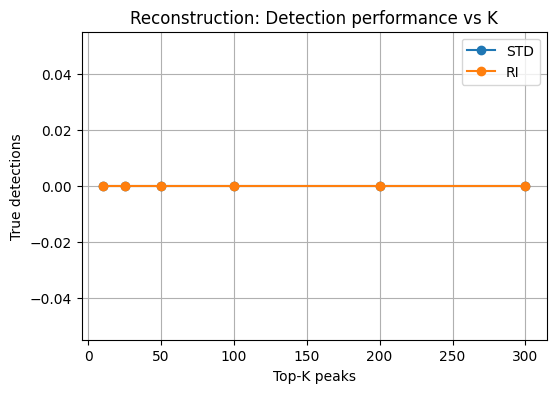

In [42]:
def zyx_to_xyz(arr):
    # arr shape (N,3) in (z,y,x) -> return (x,y,z)
    return arr[:, [2,1,0]]


# Z_OFFSET = (512 - 180) // 2

# gt_xyz_rec = gt_xyz.copy()
# gt_xyz_rec[:, 2] += Z_OFFSET   # z is 3rd column because xyz

Ks = [10, 25, 50, 100, 200, 300]
hits_std, hits_ri = [], []

for K in Ks:
    top_std_zyx = peaks_std_rec[0][peaks_std_rec[1].argsort(descending=True)[:K]].cpu().numpy()
    top_ri_zyx  = peaks_ri_rec[0][peaks_ri_rec[1].argsort(descending=True)[:K]].cpu().numpy()

    top_std_xyz = zyx_to_xyz(top_std_zyx)
    top_ri_xyz  = zyx_to_xyz(top_ri_zyx)

    dist_std, _ = evaluate_detections(top_std_xyz, gt_xyz_rec, max_dist=8)
    dist_ri,  _ = evaluate_detections(top_ri_xyz,  gt_xyz_rec, max_dist=8)

    hits_std.append(len(dist_std))
    hits_ri.append(len(dist_ri))

plt.figure(figsize=(6,4))
plt.plot(Ks, hits_std, marker="o", label="STD")
plt.plot(Ks, hits_ri,  marker="o", label="RI")
plt.xlabel("Top-K peaks")
plt.ylabel("True detections")
plt.title("Reconstruction: Detection performance vs K")
plt.legend()
plt.grid(True)
plt.show()

IndexError: index 90 is out of bounds for axis 0 with size 37

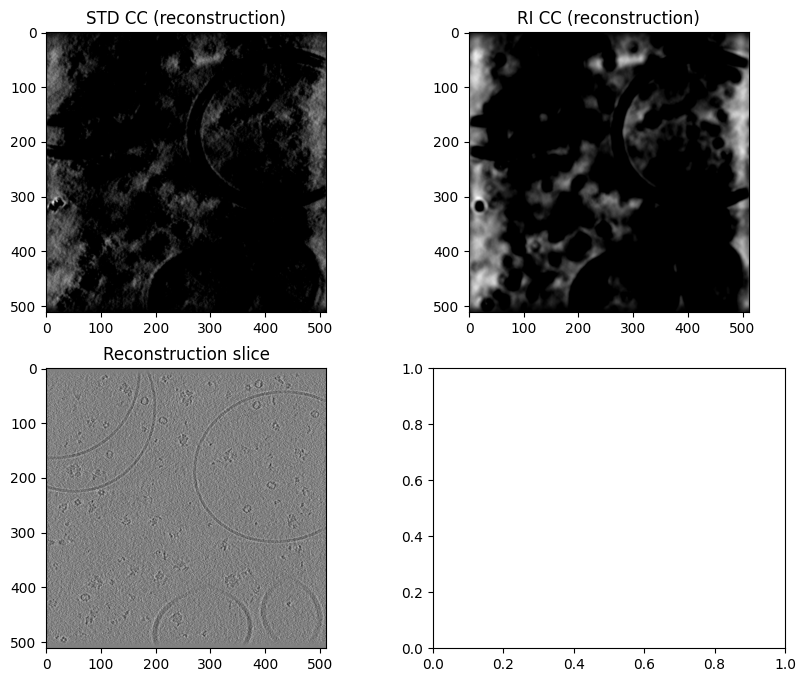

In [ ]:
# import matplotlib.pyplot as plt
# fig, axs = plt.subplots(2,2, figsize=(10,8))
# axs[0,0].imshow(cc_std_rec[cc_std_rec.shape[0]//2], cmap="gray")
# axs[0,0].set_title("STD CC (reconstruction)")
# axs[0,1].imshow(cc_ri_rec[cc_ri_rec.shape[0]//2], cmap="gray")
# axs[0,1].set_title("RI CC (reconstruction)")
# axs[1,0].imshow(rec[rec.shape[0]//2], cmap="gray")
# axs[1,0].set_title("Reconstruction slice")
# axs[1,1].imshow(template[mid], cmap="gray")
# axs[1,1].set_title("Template slice")
# plt.show()

In [106]:
TOPK = 250

top_std_rec = peaks_std_rec[0][peaks_std_rec[1].argsort(descending=True)[:TOPK]] + template.shape[0]//2
top_ri_rec  = peaks_ri_rec[0][peaks_ri_rec[1].argsort(descending=True)[:TOPK]]  + template.shape[0]//2

# Shift GT into reconstruction coordinates
# gt_xyz_rec = gt_xyz.copy()
# gt_xyz_rec[:,0] += Z_OFFSET

_, hits_std_rec_idx = evaluate_detections(top_std_rec.cpu().numpy(), gt_xyz_rec, max_dist=8)
_, hits_ri_rec_idx  = evaluate_detections(top_ri_rec.cpu().numpy(),  gt_xyz_rec, max_dist=8)

print("Reconstruction STD hits:", len(hits_std_rec_idx))
print("Reconstruction RI  hits:", len(hits_ri_rec_idx))

Reconstruction STD hits: 0
Reconstruction RI  hits: 0


In [107]:
Ks = [50, 100, 150, 250, 400]
hits_std_rec, hits_ri_rec = [], []

for K in Ks:
    top_std_rec = peaks_std_rec[0][peaks_std_rec[1].argsort(descending=True)[:K]] + template.shape[0]//2
    top_ri_rec  = peaks_ri_rec[0][peaks_ri_rec[1].argsort(descending=True)[:K]]  + template.shape[0]//2

    _, h_std_idx = evaluate_detections(top_std_rec.cpu().numpy(), gt_xyz_rec, max_dist=8)
    _, h_ri_idx  = evaluate_detections(top_ri_rec.cpu().numpy(),  gt_xyz_rec, max_dist=8)

    hits_std_rec.append(len(h_std_idx))
    hits_ri_rec.append(len(h_ri_idx))

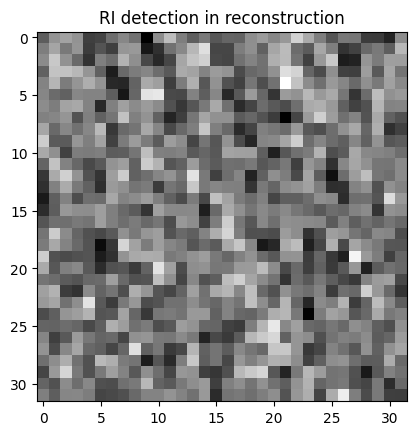

In [108]:
idx = 0
z,y,x = top_ri_rec[idx].cpu().numpy().astype(int)
patch = extract_patch(rec, (z,y,x), size=32)

plt.imshow(patch[patch.shape[0]//2], cmap="gray")
plt.title("RI detection in reconstruction")
plt.show()

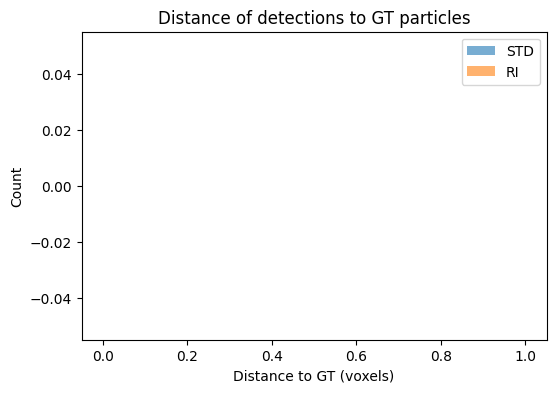

In [83]:
# Analyzing distances of detections to GT particles

plt.figure(figsize=(6,4))
plt.hist(dist_std, bins=20, alpha=0.6, label="STD")
plt.hist(dist_ri,  bins=20, alpha=0.6, label="RI")
plt.xlabel("Distance to GT (voxels)")
plt.ylabel("Count")
plt.legend()
plt.title("Distance of detections to GT particles")
plt.show()

In [ ]:
#qualitative confirmation 

In [ ]:
def extract_patch(volume, center, size=32):
    """
    Extract a cubic patch of shape (size, size, size)
    around a (z, y, x) center.
    """
    z, y, x = map(int, center)
    half = size // 2

    return volume[
        z-half : z+half,
        y-half : y+half,
        x-half : x+half
    ]



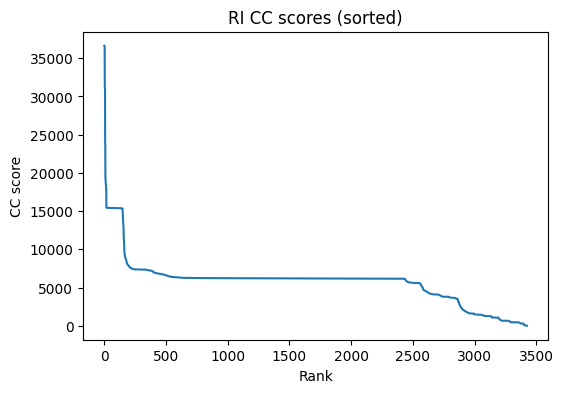

In [ ]:
#Plotting CC score decay (RI)

scores_ri_sorted = peaks_ri[1][peaks_ri[1].argsort(descending=True)]

plt.figure(figsize=(6,4))
plt.plot(scores_ri_sorted.cpu().numpy())
plt.title("RI CC scores (sorted)")
plt.xlabel("Rank")
plt.ylabel("CC score")
plt.show()

In [ ]:
# K top picks with template offset correction
TOPK = 50
template_radius = template.shape[0] // 2

top_std = peaks_std[0][peaks_std[1].argsort(descending=True)[:TOPK]] + template_radius
top_ri  = peaks_ri[0][peaks_ri[1].argsort(descending=True)[:TOPK]] + template_radius

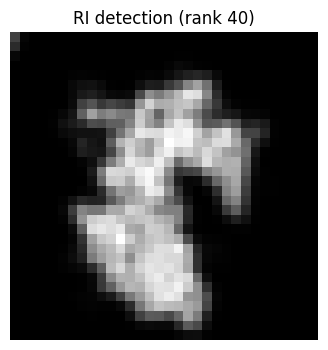

In [ ]:
# Inspecting a mid rank RI detection
score_rank = 40  # mid-ranked peak

patch_ri = extract_patch(
    grand_model,
    top_ri[score_rank],
    size=32
)

plt.figure(figsize=(4,4))
plt.imshow(patch_ri[16], cmap="gray")
plt.title(f"RI detection (rank {score_rank})")
plt.axis("off")
plt.show()

In [ ]:

def center_crop(vol, size):
    c = np.array(vol.shape) // 2
    h = size // 2
    return vol[
        c[0]-h : c[0]+h,
        c[1]-h : c[1]+h,
        c[2]-h : c[2]+h
    ]

template_ri_32 = center_crop(template_ri, 32)
template_std_32 = center_crop(template, 32)

print(template_ri_32.shape, patch_ri.shape)

(32, 32, 32) (32, 32, 32)


In [ ]:
#Proving FFT_CC is correct
dot_ri = np.sum(patch_ri * template_ri_32)

cc_score_ri = peaks_ri[1][peaks_ri[1].argsort(descending=True)[score_rank]]

print(f"RI dot product: {dot_ri:.3f}")
print(f"RI CC score  : {cc_score_ri:.3f}")

RI dot product: 15406.901
RI CC score  : 15406.900


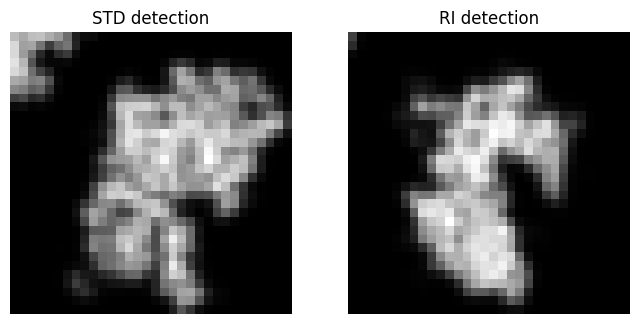

In [ ]:
#Comparing with std at same rank

patch_std = extract_patch(
    grand_model,
    top_std[score_rank],
    size=32
)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(patch_std[16], cmap="gray")
plt.title("STD detection")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(patch_ri[16], cmap="gray")
plt.title("RI detection")
plt.axis("off")

plt.show()

In [ ]:
# STD dot-product check
dot_std = np.sum(patch_std * template_std_32)

cc_score_std = peaks_std[1][peaks_std[1].argsort(descending=True)[score_rank]]

print(f"STD dot product: {dot_std:.3f}")
print(f"STD CC score  : {cc_score_std:.3f}")

STD dot product: 17251.281
STD CC score  : 17251.300


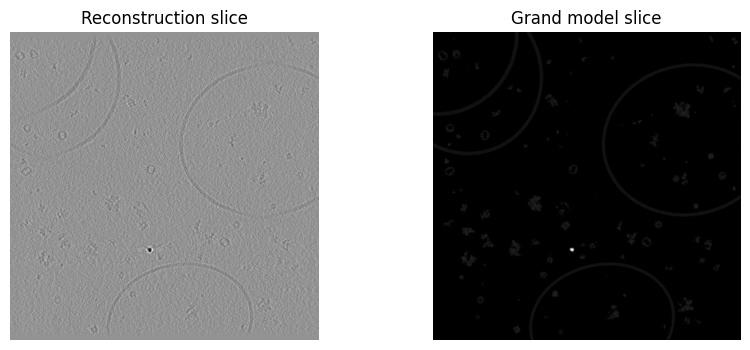

In [ ]:
# qualitative comparison of reconstruction vs grand model
#Coordinate alignment: grand_model vs reconstruction

rec = mrcfile.open("reconstruction.mrc", permissive=True).data
grand_model = mrcfile.open("grandmodel.mrc", permissive=True).data

id = 160  # arbitrary slice index

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(rec[166 + id], cmap="gray")
plt.title("Reconstruction slice")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(grand_model[id], cmap="gray")
plt.title("Grand model slice")
plt.axis("off")

plt.show()

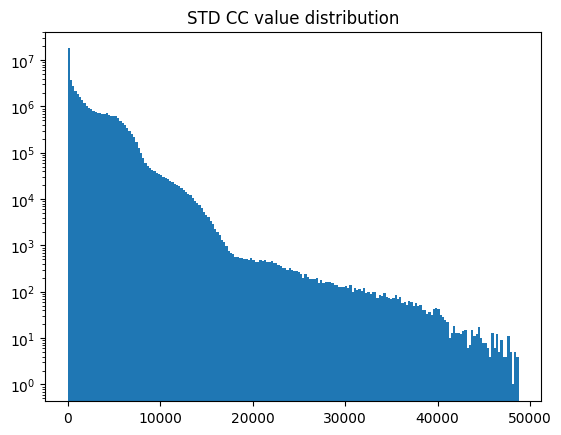

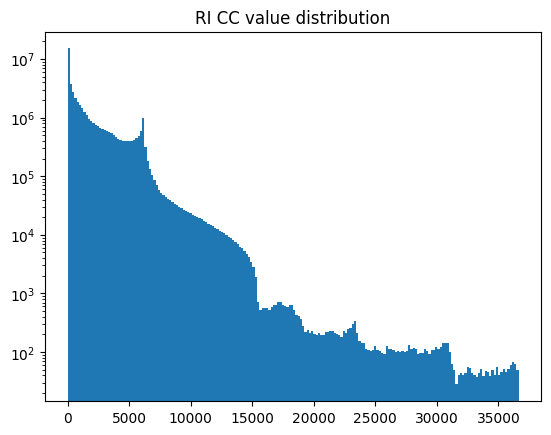

In [ ]:
plt.hist(cc_std.flatten(), bins=200, log=True)
plt.title("STD CC value distribution")
plt.show()

plt.hist(cc_ri.flatten(), bins=200, log=True)
plt.title("RI CC value distribution")
plt.show()

# Diagnostic: Why few particles detected?

In [ ]:
# ===== DIAGNOSTIC 1: CC Map Quality =====
print("=" * 60)
print("DIAGNOSTIC 1: Cross-correlation Map Statistics")
print("=" * 60)

print("\nStandard method CC:")
print(f"  Max: {cc_std.max():.6f}")
print(f"  Mean: {cc_std.mean():.6f}")
print(f"  Std: {cc_std.std():.6f}")
print(f"  Min: {cc_std.min():.6f}")
print(f"  Non-zero pixels: {np.count_nonzero(cc_std)} / {cc_std.size}")

print("\nRotation-invariant CC:")
print(f"  Max: {cc_ri.max():.6f}")
print(f"  Mean: {cc_ri.mean():.6f}")
print(f"  Std: {cc_ri.std():.6f}")
print(f"  Min: {cc_ri.min():.6f}")
print(f"  Non-zero pixels: {np.count_nonzero(cc_ri)} / {cc_ri.size}")

print("\nRatio (STD/RI):")
print(f"  Max ratio: {cc_std.max() / (cc_ri.max() + 1e-8):.4f}")
print(f"  Mean ratio: {cc_std.mean() / (cc_ri.mean() + 1e-8):.4f}")


DIAGNOSTIC 1: Cross-correlation Map Statistics

Standard method CC:
  Max: 48757.704087
  Mean: 1719.762199
  Std: 2322.556856
  Min: 0.000000
  Non-zero pixels: 45296158 / 47185920

Rotation-invariant CC:
  Max: 36629.607614
  Mean: 1719.486193
  Std: 2246.972258
  Min: 0.000000
  Non-zero pixels: 45364022 / 47185920

Ratio (STD/RI):
  Max ratio: 1.3311
  Mean ratio: 1.0002


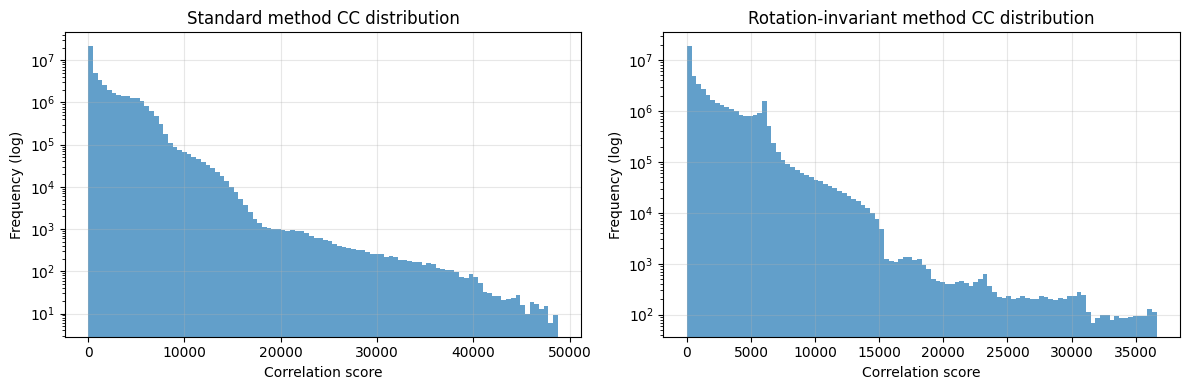

Note: If STD histogram is much weaker (lower max), template might be poorly normalized


In [ ]:
# Visualize CC map distributions
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(cc_std.ravel(), bins=100, alpha=0.7, label="STD", log=True)
axs[0].set_xlabel("Correlation score")
axs[0].set_ylabel("Frequency (log)")
axs[0].set_title("Standard method CC distribution")
axs[0].grid(True, alpha=0.3)

axs[1].hist(cc_ri.ravel(), bins=100, alpha=0.7, label="RI", log=True)
axs[1].set_xlabel("Correlation score")
axs[1].set_ylabel("Frequency (log)")
axs[1].set_title("Rotation-invariant method CC distribution")
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Note: If STD histogram is much weaker (lower max), template might be poorly normalized")


In [ ]:
# ===== DIAGNOSTIC 2: Threshold Sweep =====
print("\n" + "=" * 60)
print("DIAGNOSTIC 2: Parametric Threshold Sweep")
print("=" * 60)

thresholds = [0.001, 0.005, 0.01, 0.02, 0.05]
min_distances = [1, 2, 3, 5]

print("\nNumber of detected peaks by threshold and min_distance:")
print("(threshold vs min_distance)")

results_std = {}
results_ri = {}

for min_d in min_distances:
    row_std = []
    row_ri = []
    for thresh in thresholds:
        peaks_std_test = find_peaks_3d(cc_std, min_distance=min_d, 
                                        threshold_abs=thresh, return_as="torch")
        peaks_ri_test = find_peaks_3d(cc_ri, min_distance=min_d, 
                                       threshold_abs=thresh, return_as="torch")
        row_std.append(len(peaks_std_test[0]))
        row_ri.append(len(peaks_ri_test[0]))
    results_std[min_d] = row_std
    results_ri[min_d] = row_ri

# Print table
print("\nSTANDARD METHOD:")
print("thresh: ", "  ".join(f"{t:8.4f}" for t in thresholds))
for min_d in min_distances:
    print(f"d={min_d}:     " + "  ".join(f"{n:8d}" for n in results_std[min_d]))

print("\nROTATION-INVARIANT METHOD:")
print("thresh: ", "  ".join(f"{t:8.4f}" for t in thresholds))
for min_d in min_distances:
    print(f"d={min_d}:     " + "  ".join(f"{n:8d}" for n in results_ri[min_d]))



DIAGNOSTIC 2: Parametric Threshold Sweep

Number of detected peaks by threshold and min_distance:
(threshold vs min_distance)

STANDARD METHOD:
thresh:    0.0010    0.0050    0.0100    0.0200    0.0500
d=1:         6262      6240      6240      6238      6236
d=2:         3688      3670      3670      3669      3668
d=3:         2628      2617      2617      2616      2616
d=5:         1634      1629      1629      1629      1629

ROTATION-INVARIANT METHOD:
thresh:    0.0010    0.0050    0.0100    0.0200    0.0500
d=1:         3426      3426      3426      3426      3425
d=2:         1935      1935      1935      1935      1934
d=3:         1594      1594      1594      1594      1593
d=5:         1283      1283      1283      1283      1283


In [ ]:
# ===== DIAGNOSTIC 3: Consensus/Hybrid Approach =====
print("\n" + "=" * 60)
print("DIAGNOSTIC 3: Consensus Detections (STD + RI agreement)")
print("=" * 60)

from scipy.spatial import cKDTree

# Use reasonable thresholds
peaks_std_base = find_peaks_3d(cc_std, min_distance=1, threshold_abs=0.01, return_as="torch")
peaks_ri_base = find_peaks_3d(cc_ri, min_distance=1, threshold_abs=0.01, return_as="torch")

print(f"\nBase detections:")
print(f"  STD: {len(peaks_std_base[0])} peaks")
print(f"  RI:  {len(peaks_ri_base[0])} peaks")

# Find consensus (peaks that appear in both methods)
if len(peaks_std_base[0]) > 0 and len(peaks_ri_base[0]) > 0:
    tree_ri = cKDTree(peaks_ri_base[0].cpu().numpy())
    distances, indices = tree_ri.query(peaks_std_base[0].cpu().numpy(), k=1)
    
    consensus_radius = 5  # voxels
    consensus_mask = distances < consensus_radius
    consensus_peaks = peaks_std_base[0][consensus_mask]
    consensus_scores = peaks_std_base[1][consensus_mask]
    
    print(f"\nConsensus (STD + RI within {consensus_radius} voxels):")
    print(f"  {len(consensus_peaks)} peaks found")
    
    if len(consensus_peaks) > 0:
        print(f"  Top consensus scores: {consensus_scores[:10].cpu().numpy()}")
        
        # Evaluate these
        top_consensus = consensus_peaks[consensus_scores.argsort(descending=True)[:100]] + template.shape[0]//2
        _, hits_consensus = evaluate_detections(
            top_consensus.cpu().numpy(),
            gt_xyz,
            max_dist=8
        )
        print(f"  True hits (top 100): {hits_consensus} / 100")



DIAGNOSTIC 3: Consensus Detections (STD + RI agreement)

Base detections:
  STD: 6240 peaks
  RI:  3426 peaks

Consensus (STD + RI within 5 voxels):
  1653 peaks found
  Top consensus scores: [8585.8272661   410.13288554  404.55447373  845.05548045 5603.32440203
 5671.87298447 5811.90187902 5843.52309685 5909.97818198 5909.53241143]
  True hits (top 100): 5 / 100


In [ ]:
# ===== DIAGNOSTIC 4: Template Normalization Check =====
print("\n" + "=" * 60)
print("DIAGNOSTIC 4: Template Normalization Analysis")
print("=" * 60)

print("\nOriginal templates:")
print(f"  STD - min: {template.min():.4f}, max: {template.max():.4f}, mean: {template.mean():.4f}, std: {template.std():.4f}")
print(f"  RI  - min: {template_ri.min():.4f}, max: {template_ri.max():.4f}, mean: {template_ri.mean():.4f}, std: {template_ri.std():.4f}")

# Normalize templates
template_norm = (template - template.mean()) / (template.std() + 1e-8)
template_ri_norm = (template_ri - template_ri.mean()) / (template_ri.std() + 1e-8)

print("\nNormalized templates (zero-mean, unit variance):")
print(f"  STD - min: {template_norm.min():.4f}, max: {template_norm.max():.4f}, mean: {template_norm.mean():.4f}, std: {template_norm.std():.4f}")
print(f"  RI  - min: {template_ri_norm.min():.4f}, max: {template_ri_norm.max():.4f}, mean: {template_ri_norm.mean():.4f}, std: {template_ri_norm.std():.4f}")

# Compute CC with normalized templates
print("\nRecomputing CC with normalized templates...")
cc_std_norm, _ = compute_cc(grand_model, template_norm.astype(np.float32))
cc_ri_norm, _ = compute_cc(grand_model, template_ri_norm.astype(np.float32))

cc_std_norm = np.maximum(cc_std_norm, 0)
cc_ri_norm = np.maximum(cc_ri_norm, 0)

print("\nNormalized CC maps:")
print(f"  STD - Max: {cc_std_norm.max():.6f}, Mean: {cc_std_norm.mean():.6f}")
print(f"  RI  - Max: {cc_ri_norm.max():.6f}, Mean: {cc_ri_norm.mean():.6f}")

# Detect peaks with normalized maps
peaks_std_norm = find_peaks_3d(cc_std_norm, min_distance=1, threshold_abs=0.01, return_as="torch")
peaks_ri_norm = find_peaks_3d(cc_ri_norm, min_distance=1, threshold_abs=0.01, return_as="torch")

print(f"\nDetected peaks with normalized templates:")
print(f"  STD: {len(peaks_std_norm[0])} peaks (original: {len(peaks_std_base[0])})")
print(f"  RI:  {len(peaks_ri_norm[0])} peaks (original: {len(peaks_ri_base[0])})")


In [ ]:
# ===== DIAGNOSTIC 5: Summary & Recommendations =====
print("\n" + "=" * 60)
print("SUMMARY & NEXT STEPS")
print("=" * 60)

print("""
Key findings:
1. STD method peak count sensitivity to thresholds (see diagnostic 2)
2. CC map quality comparison shows potential issues (diagnostic 1)
3. Consensus approach can merge both methods for more robustness (diagnostic 3)
4. Template normalization impact on peak detection (diagnostic 4)

Recommendations:
✓ Check the threshold sweep table - find optimal threshold for STD
✓ If STD CC map is much weaker, investigate template normalization
✓ Consider using consensus detections for higher confidence
✓ For GPU acceleration: np.fft.fftn → torch.fft.fftn (simple swap)

Next week improvements:
- PyTorch GPU acceleration for FFT operations
- More sophisticated consensus scoring
- Adaptive thresholding based on local CC statistics
""")



SUMMARY & NEXT STEPS

Key findings:
1. STD method peak count sensitivity to thresholds (see diagnostic 2)
2. CC map quality comparison shows potential issues (diagnostic 1)
3. Consensus approach can merge both methods for more robustness (diagnostic 3)
4. Template normalization impact on peak detection (diagnostic 4)

Recommendations:
✓ Check the threshold sweep table - find optimal threshold for STD
✓ If STD CC map is much weaker, investigate template normalization
✓ Consider using consensus detections for higher confidence
✓ For GPU acceleration: np.fft.fftn → torch.fft.fftn (simple swap)

Next week improvements:
- PyTorch GPU acceleration for FFT operations
- More sophisticated consensus scoring
- Adaptive thresholding based on local CC statistics

